# Loading libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.externals import joblib
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV 

/Users/rafik/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rafik/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [4]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Preparing data

In [5]:
dtrain = pd.read_csv('data/train.csv',index_col='id',na_values=-1)
Kaggle_test = pd.read_csv('data/test.csv',index_col='id',na_values=-1)

In [6]:
def Transform(data, fill_na=-1, drop_first= False, drop_ps_car_11_cat=False):
    
    cat_f = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
    bin_f = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
    num_f = list(set(list(data)) - set(cat_f)- set(bin_f))
    
    if drop_ps_car_11_cat : cat_f.remove('ps_car_11_cat')
        
    for var in cat_f:
        data[var] = data[var].astype('category')
        
    data_cnt = data[num_f].fillna(fill_na)
    data_bin = data[bin_f]
    data_cat = pd.get_dummies(data[cat_f],
                              prefix_sep='#',
                              drop_first=drop_first)

    return pd.concat([data_cnt, data_bin, data_cat], axis=1);

In [7]:
dtrain = Transform(dtrain, drop_first= False, drop_ps_car_11_cat= False)
Kaggle_test = Transform(Kaggle_test, drop_first= False, drop_ps_car_11_cat= False)

In [8]:
predictors = list(Kaggle_test)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors], dtrain['target'], stratify=dtrain['target'], test_size=0.3, random_state=42)

# Gini

In [10]:
def gini(pred, y):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def normalized_gini(pred, y):
    return gini(pred, y) / gini(y, y)

# custom normalized gini score for xgb model
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', normalized_gini(pred, y)

# Usefull functions

In [11]:
porto_test_id = pd.read_csv('data/test.csv',usecols=['id'])
def make_submission(name, pred):
    s = porto_test_id['id'].to_frame()
    s['target'] = pred
    s.to_csv('Submissions/'+name+'.csv',index=False)

In [17]:
def rnd_gini(clf):
    x = datetime.now()
    clf.fit(X_train, y_train, eval_metric='auc')
    y = datetime.now()
    print('Time to fit : ' + str(x-y))
    tr = normalized_gini(clf.predict_proba(X_train)[:,1],y_train)
    te = normalized_gini(clf.predict_proba(X_test)[:,1],y_test)
    print('Train-gini :', tr)
    print('Test-gini :',  te)
    print('Difference-gini :', tr-te)
    x = str(datetime.now())
    joblib.dump(clf, "pkl/"+ x +".pkl")
    print("Model file : pkl/"+ x +".pkl")

# xgb Tunning

In [31]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50, target='target'):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round = alg.get_params()['n_estimators'],
                          nfold = cv_folds,
                          metrics='auc',
                          feval=gini_xgb,
                          maximize = True,
                          early_stopping_rounds = early_stopping_rounds,
                          verbose_eval = 50,
                          #show_progress=False
                         )
        alg.set_params(n_estimators=cvresult.shape[0])
        
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
    # dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    print ("\nModel Report")
    print('n_estimators :', cvresult.shape[0])
    print ("gini Score (Train): %f" % normalized_gini(dtrain_predprob, dtrain['target']))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-gini:0.21533+0.00323095	test-gini:0.204464+0.00616712
[50]	train-gini:0.310716+0.002451	test-gini:0.269956+0.00742025
[100]	train-gini:0.361378+0.00219121	test-gini:0.278935+0.00673339
[150]	train-gini:0.396117+0.00230822	test-gini:0.279967+0.00687031

Model Report
n_estimators : 142
gini Score (Train): 0.373179


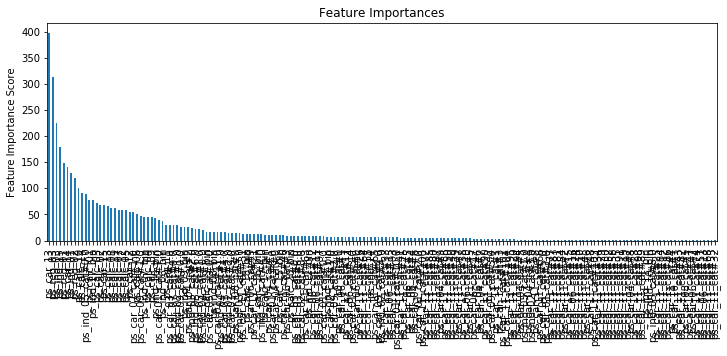

In [32]:
xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=500,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

modelfit(xgb1, dtrain, predictors,early_stopping_rounds=50)

In [ ]:
param_test1 = {
 'max_depth':[3,5],
 'min_child_weight':[3,5]
}

clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

gsearch1 = GridSearchCV(estimator = clf,
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False,
                        cv=5,
                        verbose=2)

gsearch1.fit(dtrain[predictors],dtrain['target'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# Tunning max_depth and min_child_weight

In [18]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=3,
                    min_child_weight=3,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:55:20.608350
Train-gini : 0.309210035529
Test-gini : 0.285614632008
Difference-gini : 0.023595403521
Model file : pkl/2018-01-12 11:44:58.143628.pkl


In [19]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=3,
                    min_child_weight=5,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:55:13.772748
Train-gini : 0.30909295621
Test-gini : 0.286052692454
Difference-gini : 0.0230402637565
Model file : pkl/2018-01-12 11:50:29.175052.pkl


In [20]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=5,
                    min_child_weight=3,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:52:34.558502
Train-gini : 0.394361187563
Test-gini : 0.284801209575
Difference-gini : 0.109559977988
Model file : pkl/2018-01-12 11:58:04.393804.pkl


In [21]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=5,
                    min_child_weight=5,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:52:18.288253
Train-gini : 0.390383082994
Test-gini : 0.28524190456
Difference-gini : 0.105141178434
Model file : pkl/2018-01-12 12:05:56.074664.pkl


In [22]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=5,
                    min_child_weight=6,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:52:15.220556
Train-gini : 0.388170000337
Test-gini : 0.285406526638
Difference-gini : 0.102763473699
Model file : pkl/2018-01-12 12:14:19.636535.pkl


In [23]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=4,
                    min_child_weight=6,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:53:42.422612
Train-gini : 0.343126776413
Test-gini : 0.288112957406
Difference-gini : 0.0550138190073
Model file : pkl/2018-01-12 12:20:59.873228.pkl


In [25]:
clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=142,
                    max_depth=3,
                    min_child_weight=6,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)


rnd_gini(clf)

Time to fit : -1 day, 23:55:12.087251
Train-gini : 0.308873376514
Test-gini : 0.286637411887
Difference-gini : 0.0222359646271
Model file : pkl/2018-01-12 12:26:17.326665.pkl


Best max_depth = 4
Best min_child_weight = 6

# Tunning gamma

In [36]:
gamma = [0.5/10,1.5/10,2.0/10]

In [37]:
for g in gamma :
    print('Gamma =',g)
    clf = XGBClassifier(learning_rate =0.1,
                        n_estimators=142,
                        max_depth=4,
                        min_child_weight=6,
                        gamma=g,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective= 'binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        seed=27)


    rnd_gini(clf)

Gamma = 0.05
Time to fit : -1 day, 23:53:20.529972
Train-gini : 0.343126776413
Test-gini : 0.288112957406
Difference-gini : 0.0550138190073
Model file : pkl/2018-01-12 12:47:52.877094.pkl
Gamma = 0.15
Time to fit : -1 day, 23:53:59.644725
Train-gini : 0.343126776413
Test-gini : 0.288112957406
Difference-gini : 0.0550138190073
Model file : pkl/2018-01-12 12:54:02.981429.pkl
Gamma = 0.2
Time to fit : -1 day, 23:54:03.212516
Train-gini : 0.343126776413
Test-gini : 0.288112957406
Difference-gini : 0.0550138190073
Model file : pkl/2018-01-12 13:00:08.655522.pkl


In [38]:
subsample = [0.6,0.7,0.9]
colsample_bytree = [0.6,0.7,0.9]

In [40]:
for s in subsample :
    for c in colsample_bytree : 
        print('subsample =', s)
        print('colsample_bytree =', c)
        clf = XGBClassifier(learning_rate =0.1,
                            n_estimators=180,
                            max_depth=4,
                            min_child_weight=6,
                            gamma=g,
                            subsample=s,
                            colsample_bytree=c,
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=1,
                            seed=27)


        rnd_gini(clf)

subsample = 0.6
colsample_bytree = 0.6
Time to fit : -1 day, 23:53:38.281347
Train-gini : 0.35048467291
Test-gini : 0.286607735367
Difference-gini : 0.0638769375432
Model file : pkl/2018-01-12 13:50:35.487329.pkl
subsample = 0.6
colsample_bytree = 0.7
Time to fit : -1 day, 23:52:48.174875
Train-gini : 0.351482699691
Test-gini : 0.282153872859
Difference-gini : 0.0693288268319
Model file : pkl/2018-01-12 13:57:57.733296.pkl
subsample = 0.6
colsample_bytree = 0.9
Time to fit : -1 day, 23:50:41.792320
Train-gini : 0.357009201565
Test-gini : 0.282985938899
Difference-gini : 0.0740232626659
Model file : pkl/2018-01-12 14:07:26.016969.pkl
subsample = 0.7
colsample_bytree = 0.6
Time to fit : -1 day, 23:53:57.504696
Train-gini : 0.353592430676
Test-gini : 0.284184379129
Difference-gini : 0.0694080515475
Model file : pkl/2018-01-12 14:13:39.389759.pkl
subsample = 0.7
colsample_bytree = 0.7
Time to fit : -1 day, 23:52:39.005192
Train-gini : 0.354801996936
Test-gini : 0.284375644882
Difference-gi

Best subsample = 0.8

Best colsample_bytree = 0.8

In [48]:
reg_alpha = [1e-5, 1e-2, 0.1]

In [49]:
for r in reg_alpha : 
    print('reg_alpha =', r)
    clf = XGBClassifier(learning_rate =0.1,
                        n_estimators=180,
                        max_depth=4,
                        min_child_weight=6,
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha = r,
                        objective= 'binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        seed=27)


    rnd_gini(clf)

reg_alpha = 1e-05
Time to fit : -1 day, 23:51:36.014272
Train-gini : 0.358302698842
Test-gini : 0.28813743272
Difference-gini : 0.0701652661214
Model file : pkl/2018-01-12 18:03:41.251860.pkl
reg_alpha = 0.01
Time to fit : -1 day, 23:51:31.912306
Train-gini : 0.358396180425
Test-gini : 0.287503648345
Difference-gini : 0.0708925320794
Model file : pkl/2018-01-12 18:12:20.266563.pkl
reg_alpha = 0.1
Time to fit : -1 day, 23:51:40.485897
Train-gini : 0.356497591321
Test-gini : 0.28718261502
Difference-gini : 0.0693149763011
Model file : pkl/2018-01-12 18:20:50.537883.pkl


In [ ]:
clf = XGBClassifier(learning_rate =0.01,
                        n_estimators=5000,
                        max_depth=4,
                        min_child_weight=6,
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha = 0.005,
                        objective= 'binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        seed=27)


rnd_gini(clf)